# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import numpy as np

from torch import nn
from torch import optim

from src.util.image import (
    scale_image,
    reduce_depth_with_patched_autoencoder,
)
from src.util.torch_device import resolve_torch_device
from src.data.indian_pines import load_indian_pines
from src.visualization.plot import plot_segmentation_comparison
from src.model.autoencoder import SpatialAutoEncoder
from src.trainer.autoencoder_trainer import AutoEncoderTrainer
from src.loss.patch_loss import PatchLoss
from src.util.over_clustering import exponential_decay_over_clustering
from src.visualization.plot import plot_k_values

2. Prepare env

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

batch_size = 32
patch_size = 9
num_epochs = 12
learning_rate = 1e-3
fraction_of_examples = 0.1
reduced_dim_size = 100

lambda_v = 0.49
k_star_multiplier = 3
k_means_init = 3
semantic_threshold = 0.5
spatial_constraint_weights = [1, 0.5]
spatial_threshold = 8

device = resolve_torch_device()

generator = torch.Generator()
generator.manual_seed(random_seed)

In [3]:
f"Device is {device}"

'Device is mps'

3. Load dataset

In [4]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

_, x = scale_image(image)

In [5]:
num_classes = len(np.unique(labels))

f"Number of classes {num_classes}"

'Number of classes 17'

4. Reduce dimensions

In [6]:
# _, x = reduce_depth_with_pca(x, n_components=reduced_dim_size)

In [7]:
# auto_encoder_epochs = 100

# autoencoder = SymmetricPointWiseAutoEncoder([image_c, reduced_dim_size]).to(device)

# criterion = nn.MSELoss().to(device)
# optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
# trainer = AutoEncoderTrainer(
#     autoencoder,
#     criterion,
#     auto_encoder_epochs,
#     optimizer,
# )

# x = reduce_depth_with_autoencoder(x, autoencoder, trainer, device)

In [8]:
auto_encoder_epochs = 100

autoencoder = SpatialAutoEncoder(
    input_channels=image_c, embedding_size=reduced_dim_size
).to(device)

criterion = PatchLoss(nn.MSELoss()).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
trainer = AutoEncoderTrainer(
    autoencoder,
    criterion,
    auto_encoder_epochs,
    optimizer,
)

x = reduce_depth_with_patched_autoencoder(x, patch_size, autoencoder, trainer, device)

  0%|          | 0/100 [00:00<?, ?it/s]

5. Prepare dataset

In [9]:
x = x.reshape(-1, reduced_dim_size)
y = labels.reshape(-1)

4. Train model

In [10]:
k_star = num_classes * k_star_multiplier

k_values = exponential_decay_over_clustering(
    k_star=k_star, lambda_v=lambda_v, max_iter=num_epochs
)

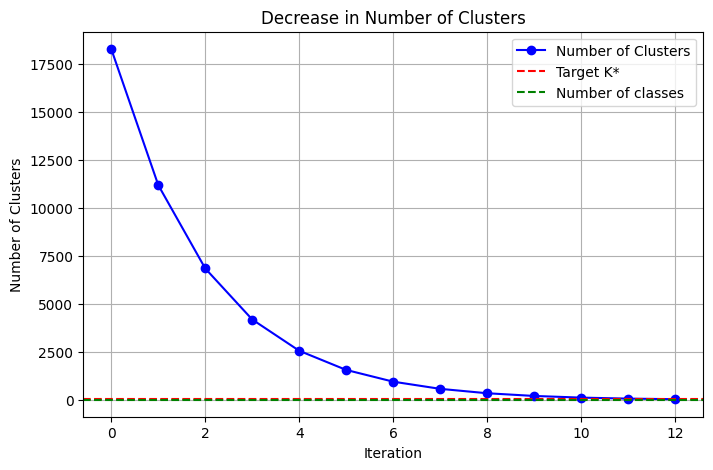

In [11]:
plot_k_values(k_values=k_values, k_star=k_star, num_classes=num_classes)

In [12]:
from sklearn.cluster import KMeans

from src.pipeline.common import introduce_semantic_constraint, introduce_spatial_constraint

original_shape = (image_h, image_w)

for num_clusters in k_values:
    clustering = KMeans(
        n_clusters=num_clusters, n_init=k_means_init, random_state=random_seed
    )

    y = y.reshape(-1)
    k = clustering.fit_predict(x)
    c = introduce_semantic_constraint(k, y, num_classes, semantic_threshold)
    y = introduce_spatial_constraint(
        c, original_shape, spatial_constraint_weights, spatial_threshold
    )

5. Display prediction

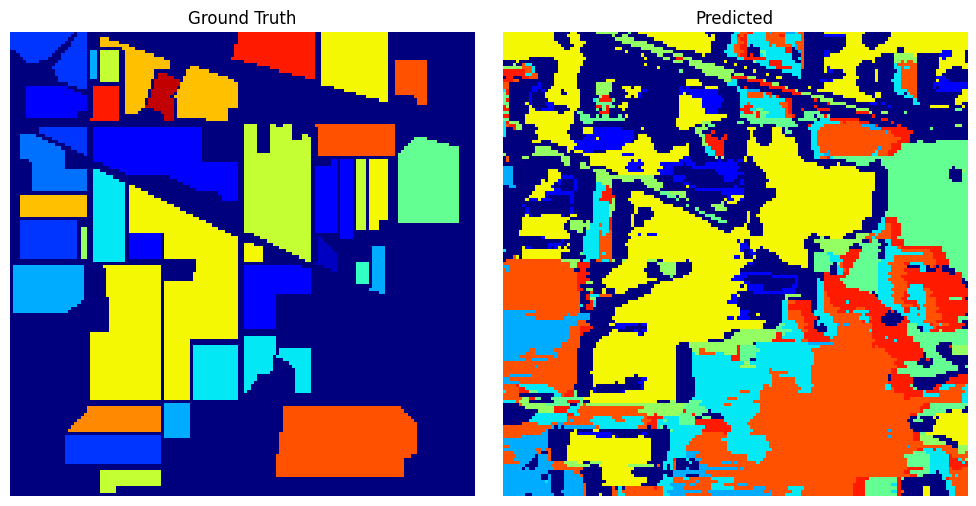

In [13]:
plot_segmentation_comparison(labels, y.reshape(original_shape))